In [1]:
import numpy as np
from rsq import SSRF
from rsq.helpers import stratified_sample, few_shot_sample

from time import time

from tqdm import tqdm
from joblib import Parallel, delayed

import pickle

In [2]:
#- Data processing 1

class Dataset:
    def __init__(self, file='cifar_100_Bit_m-r101x1_embd.p', train=True, classes=[]):
        if train:
            self.data = pickle.load(open(file, 'rb'))[0][0]
            self.targets = np.concatenate(pickle.load(open(file, 'rb'))[0][1])
        else:
            self.data = pickle.load(open(file, 'rb'))[1][0]
            self.targets = np.concatenate(pickle.load(open(file, 'rb'))[1][1])
        
        self.classes = classes

In [3]:
#- Data processing 2
file='/home/hhelm/data/cifar_100_Bit_m-r101x1_embd.p'

trainset = Dataset(file, train=True)
X = trainset.data
y = trainset.targets

testset = Dataset(file, train=False)
X_test = testset.data
y_test = testset.targets

del trainset, testset

In [6]:
def benchmark_ssrf(X, y, inds_sup, label_noise=0,):
    
    n_to_change = int(np.math.floor(label_noise * len(inds_sup)))
        
    inds_to_change = np.random.binomial(1, p=label_noise, size=len(inds_sup)).astype(bool)
    new_labels = np.random.choice(np.unique(y), np.sum(inds_to_change), replace=True)    
    
    y_ = -1 * np.ones(len(y))
    y_[inds_sup] = y[inds_sup]    
    y_[inds_sup[inds_to_change]] = new_labels
    
    ssrf = SSRF(n_trees=10, tree_split=0, semi_supervised_max_depth=10, projector='gaussian', projection_kwargs={'n_components': 64})
    
    fit_time_ = time()
    ssrf.fit(X, y_)
    fit_time = time() - fit_time_
    
    inf_time_ = time()
    accuracy = (ssrf.predict(X_test) == y_test).mean()
    inf_time = time() - inf_time_
    
    print(label_noise, accuracy, fit_time, inf_time)
    
    return accuracy, fit_time, inf_time

benchmark_ssrf_ = lambda x: benchmark_ssrf(*x)

In [8]:
np.random.seed(1)
import copy

label_noise_list = [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.8]
prop_data=[0.01, 0.02, 0.05, 0.1, 0.2, 0.5]


n_cores=10
n_mc=20

n_labeled_per_class=5

experiment_tuples = []

for j, p in enumerate(prop_data):
    for i, label_noise in enumerate(label_noise_list):
        for _ in range(n_mc):
            if p == 0:
                all_inds = few_shot_sample(y, n_samples_per_class=1)
                inds_sup = np.arange(len(all_inds))
            else:
                all_inds = stratified_sample(y, p=p, replace=False)
                inds_sup = few_shot_sample(y[all_inds], n_samples_per_class=n_labeled_per_class)
                            
            experiment_tuples.append((X[all_inds], y[all_inds], inds_sup, label_noise))
    
start_time = time()
try:
    results = Parallel(n_jobs=1)(delayed(benchmark_ssrf_)(tupl) for tupl in experiment_tuples)
    print("finished in %1.1f"%(time() - start_time))
except:
    print("error after %1.1f"%(time() - start_time))
    assert 0 == 1

error after 0.0


AssertionError: 

In [30]:
def benchmark_svc(X, y, label_noise=0):        
    inds_to_change = np.random.binomial(1, p=label_noise, size=len(y)).astype(bool)
    new_labels = np.random.choice(np.unique(y), np.sum(inds_to_change), replace=True)    
 
    y[inds_to_change] = new_labels
    
    svc = SVC()
    fit_time_ = time()
    svc.fit(X, y)
    fit_time = time() - fit_time_
    
    inf_time_ = time()
    accuracy = (svc.predict(X_test) == y_test).mean()
    inf_time = time() - inf_time_
    
    print(label_noise, accuracy, fit_time, inf_time)
    
    return accuracy, fit_time, inf_time

benchmark_svc_ = lambda x: benchmark_svc(*x)

In [31]:
np.random.seed(1)
import copy

label_noise_list = [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.8]
prop_data=[0.01]


n_cores=10
n_mc=20

n_labeled_per_class=5

experiment_tuples = []

for j, p in enumerate(prop_data):
    for i, label_noise in enumerate(label_noise_list):
        for _ in range(n_mc):
            if p == 0:
                all_inds = few_shot_sample(y, n_samples_per_class=1)
                inds_sup = np.arange(len(all_inds))
            else:
                all_inds = stratified_sample(y, p=p, replace=False)
                inds_sup = few_shot_sample(y[all_inds], n_samples_per_class=n_labeled_per_class)
                            
            experiment_tuples.append((X[all_inds[inds_sup]], y[all_inds[inds_sup]], label_noise))
    
start_time = time()
try:
    results_svc = Parallel(n_jobs=n_cores)(delayed(benchmark_svc_)(tupl) for tupl in experiment_tuples)
    print("finished in %1.1f"%(time() - start_time))
except:
    print("error after %1.1f"%(time() - start_time))
    assert 0 == 1

finished in 120.1


In [ ]:
np.array([0,0,0]).astype(bool)

In [ ]:
accuracies = np.zeros((len(prop_data), len(label_noise_list), n_mc))
fit_times = np.zeros((len(prop_data), len(label_noise_list), n_mc))
inf_times = np.zeros((len(prop_data), len(label_noise_list), n_mc))

n_p = len(prop_data)
n_l = len(label_noise_list)

for i, tupl in enumerate(results):
    
#     print(int(np.math.floor(i / (n_mc * len(label_noise_list)))), int(np.math.floor(i/n_mc)), i % n_mc)
        
    accuracies[int(np.math.floor(i / (n_mc * n_l))), int(np.math.floor(i/n_mc)) % n_l, i % n_mc] = tupl[0]
    fit_times[int(np.math.floor(i / (n_mc * n_l))), int(np.math.floor(i/n_mc)) % n_l, i % n_mc] = tupl[1]
    inf_times[int(np.math.floor(i / (n_mc * n_l))), int(np.math.floor(i/n_mc)) % n_l, i % n_mc] = tupl[2]

In [33]:
accuracies_svc = np.zeros((len(label_noise_list), n_mc))
fit_times_svc = np.zeros((len(label_noise_list), n_mc))
inf_times_svc = np.zeros((len(label_noise_list), n_mc))

n_p = len(prop_data)
n_l = len(label_noise_list)

for i, tupl in enumerate(results_svc):
    
#     print(int(np.math.floor(i / (n_mc * len(label_noise_list)))), int(np.math.floor(i/n_mc)), i % n_mc)
        
    accuracies_svc[int(np.math.floor(i/n_mc)), i % n_mc] = tupl[0]
    fit_times_svc[int(np.math.floor(i/n_mc)), i % n_mc] = tupl[1]
    inf_times_svc[int(np.math.floor(i/n_mc)), i % n_mc] = tupl[2]

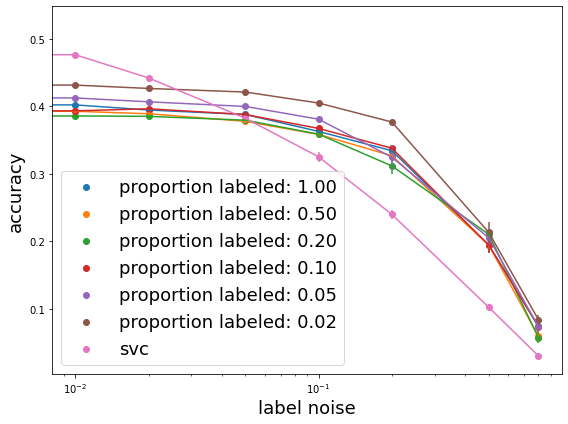

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(8,6))

# for ax_ in ax:
ax.set_xscale('log')

prop_data=[0.01, 0.02, 0.05, 0.1, 0.2, 0.5]

for i, p in enumerate(prop_data):
    prop_labeled = n_labeled_per_class * 100 / (p * len(y))
    ax.scatter(label_noise_list, np.mean(accuracies, axis=-1)[i], label='proportion labeled: %1.2f'%(prop_labeled))
    ax.errorbar(label_noise_list, np.mean(accuracies, axis=-1)[i], np.std(accuracies, axis=-1)[i] / np.sqrt(n_mc))
    
ax.scatter(label_noise_list, np.mean(accuracies_svc, axis=-1), label='svc')
ax.errorbar(label_noise_list, np.mean(accuracies_svc, axis=-1), np.std(accuracies_svc, axis=-1) / np.sqrt(n_mc))


# ax.scatter(label_noise_list, np.mean(svc_accuracies, axis=-1), label='Supervised')
# ax.errorbar(label_noise_list, np.mean(svc_accuracies, axis=-1), np.std(svc_accuracies, axis=-1) / np.sqrt(n_mc))

ax.set_ylabel('accuracy', fontsize=18)
ax.set_xlabel('label noise', fontsize=18)

ax.legend(fontsize=18)

plt.tight_layout()

In [33]:
accuracies

array([[0.4992, 0.5055, 0.5156, 0.5005, 0.5158, 0.5054, 0.505 , 0.5051,
        0.5142, 0.4957],
       [0.5054, 0.505 , 0.5051, 0.5142, 0.4957, 0.4833, 0.4771, 0.4854,
        0.4912, 0.488 ],
       [0.4833, 0.4771, 0.4854, 0.4912, 0.488 , 0.4776, 0.4702, 0.4796,
        0.4925, 0.4728],
       [0.4776, 0.4702, 0.4796, 0.4925, 0.4728, 0.4536, 0.4582, 0.4664,
        0.4538, 0.4562],
       [0.4536, 0.4582, 0.4664, 0.4538, 0.4562, 0.4619, 0.4674, 0.4703,
        0.46  , 0.4584]])